# AN2DL - Homework 1

## 1 - Libraries and Dataset Import


In [1]:
# In this notebook you will only find comments related to new/modified code
# Please refere to our notebooks FORmidable_basic_model and FORmidable_MNV3_light_custom for all commented sections
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import cv2
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras_cv import layers as kcvl
from keras import mixed_precision

tf.config.optimizer.set_jit(True)

print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(f"TensorFlow version {tf.__version__}")

np.random.seed(42)
tf.random.set_seed(42)

/home/teo/Desktop/LabANN/venvANNUbu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version 2.17.0


I0000 00:00:1732291847.678261   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732291847.713568   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732291847.717270   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
data = np.load('training_set.npz')

X = data['images']
y = data['labels']
print(X.shape, y.shape)

(13759, 96, 96, 3) (13759, 1)


## 2 - Checking for missing, duplicate values and class distribution

In [3]:
missing_targets = np.isnan(y.flatten()).any()

if not missing_targets :
    print("There are no missing or NaN values in the target vector.")

There are no missing or NaN values in the target vector.


In [4]:
# Duplicates count and removal
reshaped_X = X.reshape(X.shape[0], -1)
unique_X, unique_indices = np.unique(reshaped_X, axis=0, return_index=True)

X_unique = X[unique_indices]
y_unique = y[unique_indices]

print(f'Labels reduced from {len(y)} to {len(y_unique)}')

X = X_unique
y = y_unique

Labels reduced from 13759 to 11953


In [5]:
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Class plotting already shown in FORmidable_basic_model notebook
''''''

''

## 3 - Split dataset into Train, Test and Validation sets while maintaining the distribution

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

Training Data Shape: (8605, 96, 96, 3)
Training Label Shape: (8605, 1)
Test Data Shape: (2391, 96, 96, 3)
Test Label Shape: (2391, 1)
Validation Data Shape: (957, 96, 96, 3)
Validation Label Shape: (957, 1)


## 4 - Image Augmentation

I0000 00:00:1732291858.037406   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732291858.042857   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732291858.046496   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732291858.173005   49278 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

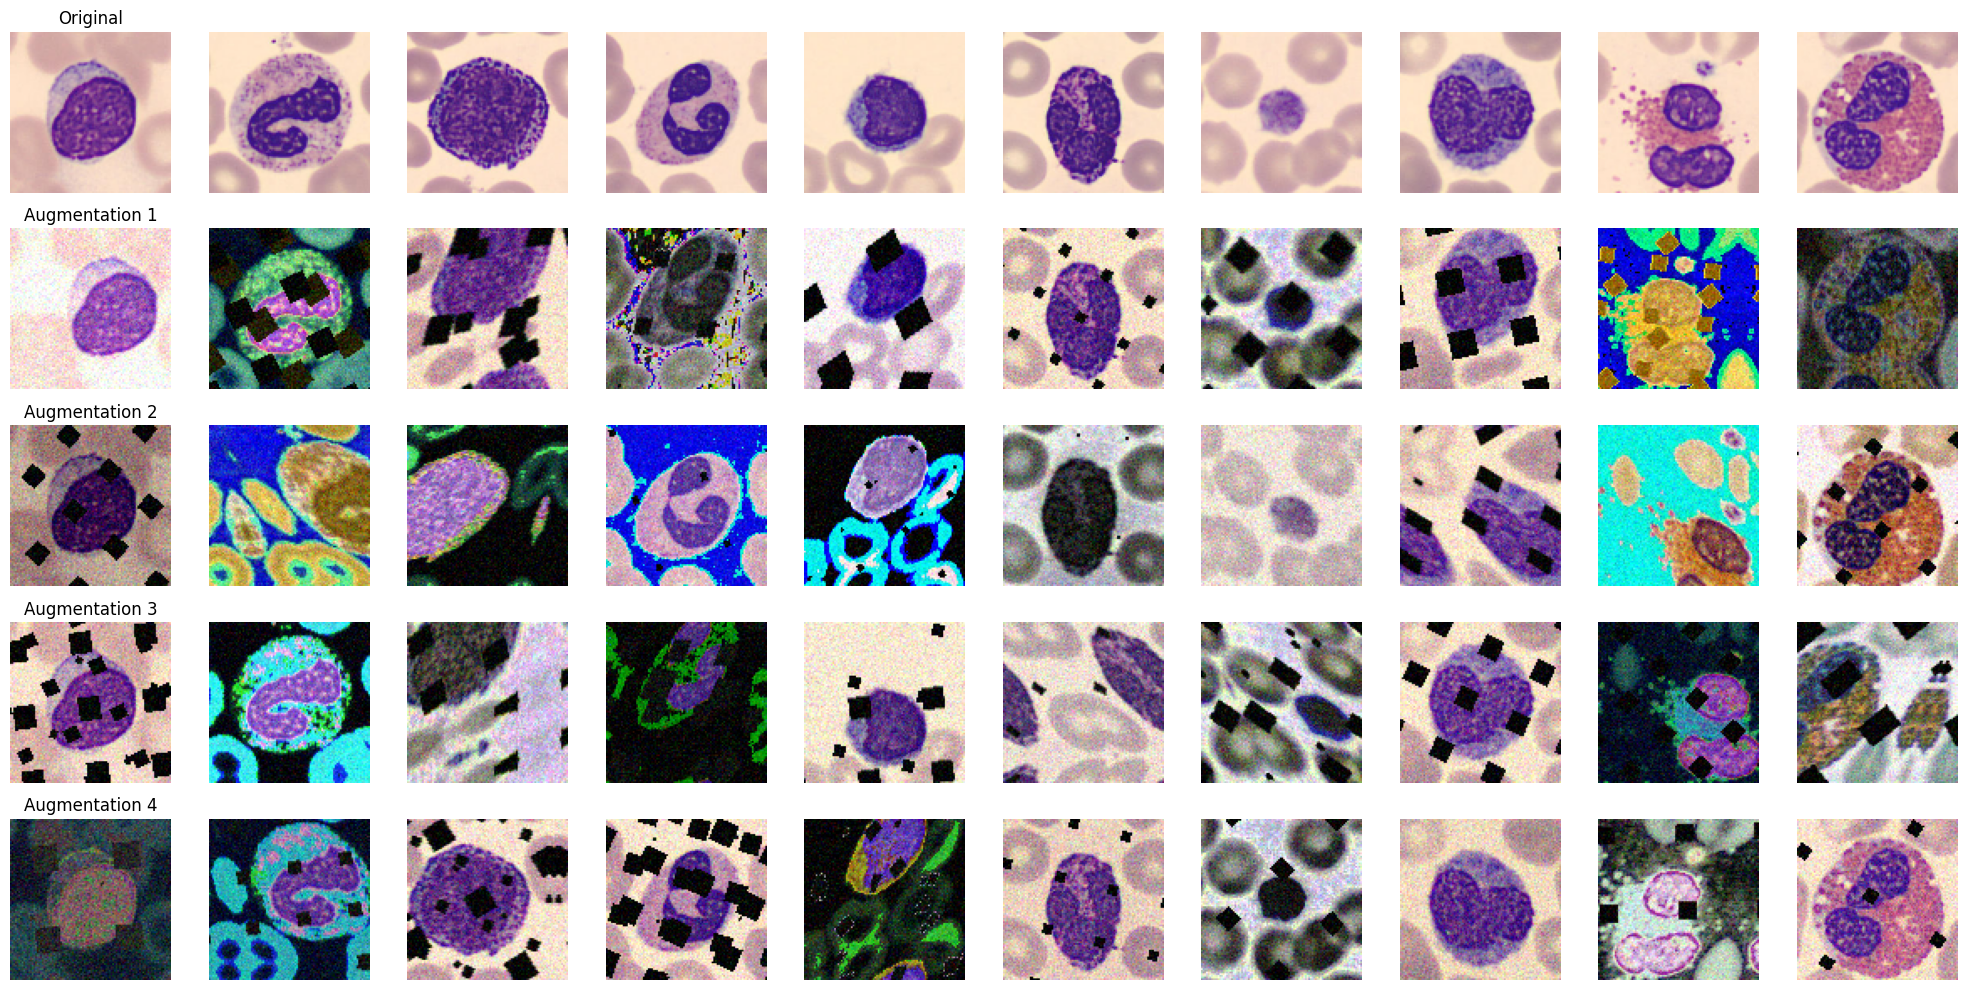

In [7]:
from preprocessing import plot_augmented_images, create_train_dataset, create_val_dataset 
batch_size = 32
target_size = (96, 96)  # No resizing applied to a custom model

plot_augmented_images(X_train, y_train, num_images=10)

train_dataset = create_train_dataset(X_train, y_train, batch_size, target_size)
val_dataset = create_val_dataset(X_val, y_val, batch_size, target_size)

# 5. Training

In [8]:
mixed_precision.set_global_policy('mixed_float16')

block_config = [ # Our only change from the previous notebook (FORmidable_MNV3_light_custom) resides in the number of filters and stacks:
    {"filters": 32, "stack": 2, "downsample": False}, 
    {"filters": 64, "stack": 3, "downsample": True},  
    {"filters": 128, "stack": 4, "downsample": True},  
    {"filters": 256, "stack": 5, "downsample": True}, 
    {"filters": 512, "stack": 5, "downsample": False}, 
    {"filters": 1024, "stack": 5, "downsample": True}, 
]

In [9]:
for batch_images, batch_labels in train_dataset.take(1):
    print("Train batch images shape:", batch_images.shape)
    print("Train batch labels shape:", batch_labels.shape)
    input_shape = batch_images.shape[1:]
    output_shape = batch_labels.shape[1]
    print("Input Shape:", input_shape)
    print("Output Shape:", output_shape)

initial_learning_rate = 1e-4

Train batch images shape: (32, 96, 96, 3)
Train batch labels shape: (32, 8)
Input Shape: (96, 96, 3)
Output Shape: 8


In [10]:
def mobilenetv3_block(x, filters, kernel_size=3, padding='same',
                      downsample=True, activation='h_swish', stack=1, name='mobilev3'):

    def h_swish(x):
        return x * tf.nn.relu6(x + 3.0) / 6.0

    activation_fn = tf.nn.relu if activation == 'relu' else h_swish

    for s in range(stack):
        input_channels = x.shape[-1]
        residual = x

        expansion_factor = 1 if input_channels == filters else 6
        expanded_channels = input_channels * expansion_factor

        if expansion_factor != 1:
            x = tfkl.Conv2D(expanded_channels, 1, padding=padding, use_bias=False, name=f'{name}_expand_{s}')(x)
            x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
            x = tfkl.Activation(activation_fn, name=f'{name}_act1_{s}')(x)

        stride = 2 if (downsample and s == 0) else 1
        x = tfkl.DepthwiseConv2D(kernel_size, strides=stride, padding=padding, use_bias=False, name=f'{name}_depthwise_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)
        x = tfkl.Activation(activation_fn, name=f'{name}_act2_{s}')(x)

        se_channels = max(1, expanded_channels // 4)
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_se_pool_{s}')(x)
        se = tfkl.Reshape((1, 1, expanded_channels))(se)
        se = tfkl.Conv2D(se_channels, 1, activation='relu', name=f'{name}_se_reduce_{s}')(se)
        se = tfkl.Conv2D(expanded_channels, 1, activation='hard_sigmoid', name=f'{name}_se_expand_{s}')(se)
        x = tfkl.Multiply(name=f'{name}_se_excite_{s}')([x, se])

        x = tfkl.Conv2D(filters, 1, padding=padding, use_bias=False, name=f'{name}_project_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(x)

        if stride == 1 and input_channels == filters:
            x = tfkl.Add(name=f'{name}_add_{s}')([residual, x])

    return x

input_layer = tfkl.Input(shape=input_shape, name='input_layer')
x = input_layer

for i, config in enumerate(block_config):
    x = mobilenetv3_block(
        x=x, 
        filters=config["filters"], 
        kernel_size=3,
        downsample=config["downsample"], 
        stack=config["stack"], 
        name=f'block_{i}'
    )

x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dense(output_shape, name='dense')(x)
x = tfkl.Activation('softmax', name='softmax')(x)

model = tfk.Model(inputs=input_layer, outputs=x, name='Custom_heavy_MobileNetV3_architecture')
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Lion(learning_rate=initial_learning_rate), metrics=['accuracy'])

model.summary(expand_nested=True, show_trainable=True)

Model: "Custom_heavy_MobileNetV3_architecture"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_expand_0  │ (None, 96, 96,  │        54 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_bn1_0     │ (None, 96, 96,  │        72 │ block_0_expan… │   Y   │
│ (BatchNormalizat… │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_act1_0    │ (None, 96, 96,  │         0 │ block_0_bn1_0… │   -   │
│ (Activation)      │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_depthwis… │ (None, 96, 96,  │       162 │ block_0_act1_… │   Y   │
│ (DepthwiseConv2D) │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_bn2_0     │ (None, 96, 96,  │        72 │ block_0_depth… │   Y   │
│ (BatchNormalizat… │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_act2_0    │ (None, 96, 96,  │         0 │ block_0_bn2_0… │   -   │
│ (Activation)      │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_se_pool_0 │ (None, 18)      │         0 │ block_0_act2_… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ reshape (Reshape) │ (None, 1, 1,    │         0 │ block_0_se_po… │   -   │
│                   │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_se_reduc… │ (None, 1, 1, 4) │        76 │ reshape[0][0]  │   Y   │
│ (Conv2D)          │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_se_expan… │ (None, 1, 1,    │        90 │ block_0_se_re… │   Y   │
│ (Conv2D)          │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_se_excit… │ (None, 96, 96,  │         0 │ block_0_act2_… │   -   │
│ (Multiply)        │ 18)             │           │ block_0_se_ex… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_project_0 │ (None, 96, 96,  │       576 │ block_0_se_ex… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_bn3_0     │ (None, 96, 96,  │       128 │ block_0_proje… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_depthwis… │ (None, 96, 96,  │       288 │ block_0_bn3_0… │   Y   │
│ (DepthwiseConv2D) │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_bn2_1     │ (None, 96, 96,  │       128 │ block_0_depth… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block_0_act2_1    │ (None, 96, 96,  │         0 │ block_0_bn2_1… │   - 

 Total params: 21,182,446 (80.80 MB)

 Trainable params: 21,123,686 (80.58 MB)

 Non-trainable params: 58,760 (229.53 KB)

In [11]:
epochs = 1000 # Setting a high number to allow for early stopping

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

In [12]:
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
    ).history

print("--- %s seconds ---" % (time.time() - start_time))

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model_filename = 'FinalSubmissions/MNV3_heavy_custom.keras'
print('Saving to', model_filename)
model.save(model_filename)

Epoch 1/1000


I0000 00:00:1732291899.945998   49721 service.cc:146] XLA service 0x57c90a4d0210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732291899.946049   49721 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
I0000 00:00:1732291900.004181   49721 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 ━━━━━━━━━━━━━━━━━━━━ 190s 397ms/step - accuracy: 0.1876 - loss: 2.6539 - val_accuracy: 0.1954 - val_loss: 2.1027 - learning_rate: 1.0000e-04
Epoch 2/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 194ms/step - accuracy: 0.3523 - loss: 1.7285 - val_accuracy: 0.1452 - val_loss: 3.6919 - learning_rate: 1.0000e-04
Epoch 3/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.4698 - loss: 1.4668 - val_accuracy: 0.5141 - val_loss: 1.3980 - learning_rate: 1.0000e-04
Epoch 4/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.5545 - loss: 1.2570 - val_accuracy: 0.3062 - val_loss: 2.5360 - learning_rate: 1.0000e-04
Epoch 5/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 194ms/step - accuracy: 0.6026 - loss: 1.0904 - val_accuracy: 0.4880 - val_loss: 1.6782 - learning_rate: 1.0000e-04
Epoch 6/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 194ms/step - accuracy: 0.6431 - loss: 0.9845 - val_accuracy: 0.6782 - val_loss: 0.8035 - learning_rate: 1.0000e-04
Epoch 7/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 

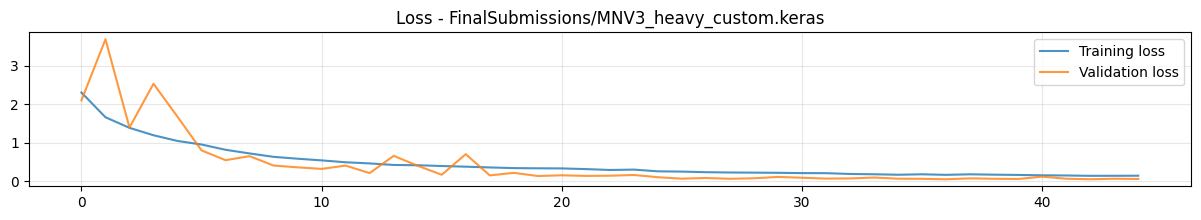

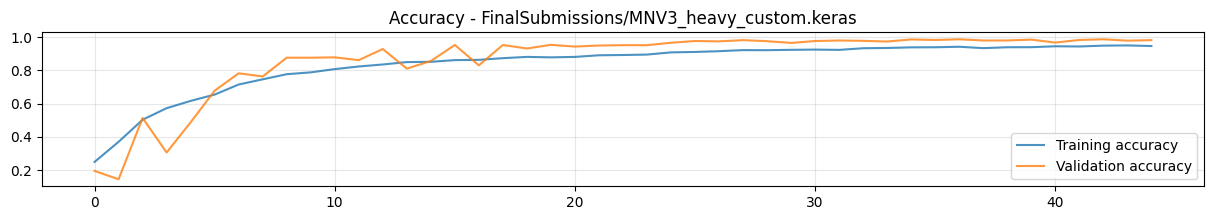

In [13]:
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title(f'Loss - {model_filename}')
plt.legend()
plt.grid(alpha=.3)

plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title(f'Accuracy - {model_filename}')
plt.legend()
plt.grid(alpha=.3)
plt.show()


# 6. Evaluating the model

(2391, 96, 96, 3) (2391, 8)
Predictions Shape: (2391, 8)
Accuracy score over the test set: 0.9762
Precision score over the test set: 0.9766
Recall score over the test set: 0.9762
F1 score over the test set: 0.9763


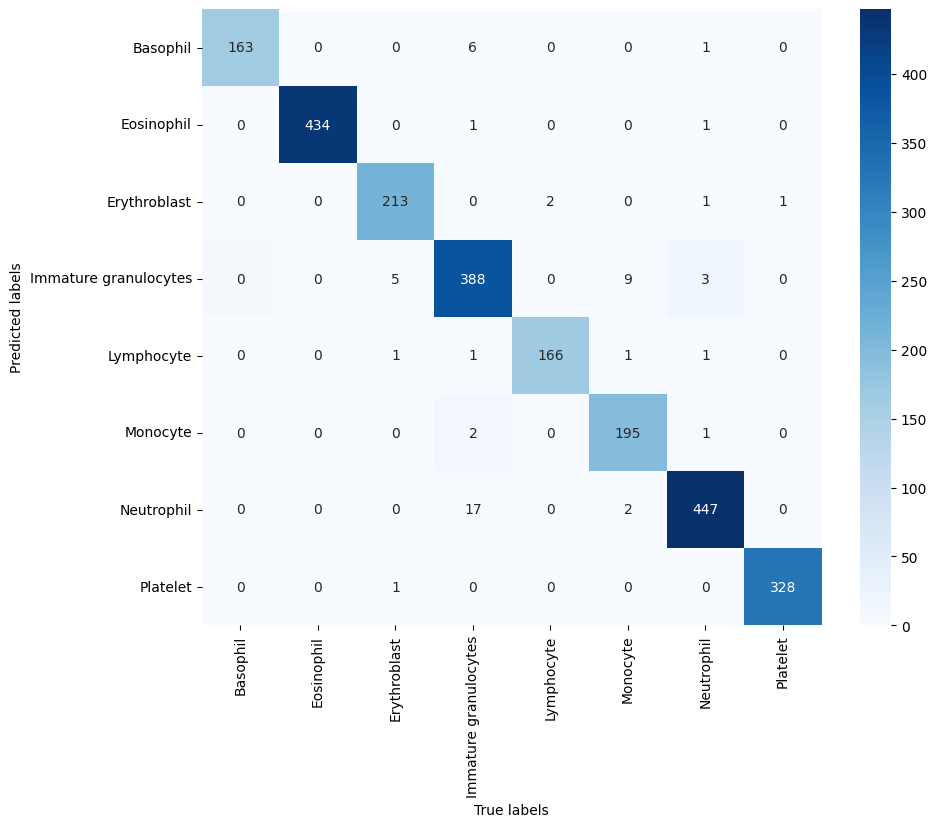

In [14]:
def h_swish(x): # Our custom object to be included in load_model
    return x * tf.nn.relu6(x + 3.0) / 6.0

model = tfk.models.load_model(model_filename, custom_objects={'h_swish': h_swish})

# Apply normalization and resizing to the test data directly, as done in the model.py submission file
X_normalized = (X_test / 127.5).astype('float32') - 1
X_resized = np.array([cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC) for img in X_normalized])
print(X_resized.shape, y_test.shape)

predictions = model.predict(X_resized, verbose=0)

print("Predictions Shape:", predictions.shape)

pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_test, axis=-1)

accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

cm = confusion_matrix(true_classes, pred_classes)

annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()